<a href="https://colab.research.google.com/github/tristanpadiou/Travel-assistant/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install langchain_google_genai
! pip install langchain-community
! pip install langgraph
! pip install pyowm
! pip install wikipedia
# ! pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=da9781145bcd31ff1fa96719753286af8d076dfea5f1d2c35bb28b129a327ceb
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia


In [90]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
import pytz
from datetime import datetime
import os
import requests
import json
# import gradio as gr


In [5]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
pse=userdata.get('programmable_search_engine')
OPENWEATHERMAP_API_KEY=userdata.get('open_weather_key')
os.environ['OPENWEATHERMAP_API_KEY']=OPENWEATHERMAP_API_KEY

In [6]:
GEMINI_MODEL='gemini-1.5-flash'

In [7]:
llm = ChatGoogleGenerativeAI(google_api_key=GOOGLE_API_KEY, model=GEMINI_MODEL, temperature=0.3)

In [8]:

trip_schedule= {'Marrakech':{'hotel': 'le clos des arts',
                           'schedule':
                            {"Jeudi 26 Décembre": [
                                {"time": "09:00", "event": "Petit Déjeuner"},
                                {"time": "10:00", "event": "Atelier de Tissage", "details": "1 personne"},
                                {"time": "16:00", "event": "Visite guidée de la Koutoubia"},
                                {"time": "19:00", "event": "Vol EJU4665 Paris", "details": "2 personnes /Couple Sekfali"},
                                {"time": "20:30", "event": "Dîner au riad", "details": "12 ou 13 personnes"},
                            ],
                            "Vendredi 27 Décembre": [
                                {"time": "09:00", "event": "Petit Déjeuner"},
                                {"time": "10:20", "event": "Vol LX2200 Genève", "details": "1 personne William Burgat"},
                                {"time": "10:00", "event": "Visite Guidée des Tombeaux Saadiens"},
                                {"time": "15:00", "event": "Visite aux Jardins de Majorelle et Musée YSL"},
                                {"time": "19:00", "event": "Transfert pour aller au restaurant AZAR"},
                                {"time": "19:30", "event": "Dîner au restaurant AZAR"},
                            ],
                            "Samedi 28 Décembre": [
                                {"time": "08:00", "event": "Petit Déjeuner"},
                                {"time": "09:00", "event": "Randonnée dans l'Atlas"},
                                {"time": "19:30", "event": "Dîner au Riad", "details": "11 personnes"},
                                {"time": "21:00", "event": "Soirée KARAOKE"},
                            ],
                            "Dimanche 29 Décembre": [
                                {"time": "09:00", "event": "Petit Déjeuner"},
                                {"time": "09:30", "event": "Arrivée de Lili-Chambre Jade"},
                                {"time": "14:30", "event": "Excursion en Quads", "details": "(2 heures)"},
                                {"time": "Dîner", "event": "Dîner au Scarabeo Camp"},
                            ],
                            "Lundi 30 Décembre": [
                                {"time": "07:00", "event": "Petit Déjeuner"},
                                {"time": "08:00", "event": "Excursion à Ouarzazate"},
                                {"time": "20:00", "event": "Dîner au Riad", "details": "12 personnes"},
                            ],
                            "Mardi 31 Décembre": [
                                {"time": "09:00", "event": "Petit Déjeuner"},
                                {"time": "10:00", "event": "Visite Guidée à la Merdersa Ben Youssef"},
                                {"time": "14:00", "event": "HAMAM et MASSAGE x 2 à vérifier"},
                                {"time": "15:30", "event": "HAMAM et MASSAGE x 2 à vérifier"},
                                {"time": "17:00", "event": "HAMAM et MASSAGE x 2 à vérifier"},
                                {"time": "17:00", "event": "Coiffeuse et vernis"},
                                {"time": "20:00", "event": "Réveillon au Riad avec DJ"},
                            ],
                            "Mercredi 1er Janvier": [
                                {"time": "12:00", "event": "HAMAM et MASSAGE à vérifier"},
                                {"time": "13:30", "event": "HAMAM et MASSAGE à vérifier"},
                                {"time": "15:00", "event": "HAMAM et MASSAGE à vérifier"},
                                {"time": "16:15", "event": "Excursion en Sidecar", "details": "(1h30)"},
                                {"time": "19:30", "event": "Dîner au Restaurant Dar Yacout"},
                            ],
                            "Jeudi 2 Janvier": [
                                {"time": "11:00", "event": "Atelier de cuisine"},
                                {"time": "14:00", "event": "Déjeuner à la terrasse"},
                                {"time": "16:30", "event": "Départ Sekfali x 2"},
                                {"time": "Programme à définir", "event": "Programme à définir"},
                            ],
                            "Vendredi Janvier": [
                                {"time": "08:00", "event": "Départ famille Padiou x 8"},
                                {"time": "09:00", "event": "Départ Rossignol x 2"},
                            ],
                        }}}



In [9]:
@tool
def trip_data_loader(tool_call_id: Annotated[str, InjectedToolCallId],filename: str) -> str:
  """
  Tool to load the trip_data, which is a pickle file.

  Include the extensions in filename. eg. file.pkl.
  """
  # with open(f'/content/drive/MyDrive/{filename}', 'rb') as f:
  #   trip_data=pickle.load(f)
  if filename=='trip_data.pkl':
    trip_data=trip_schedule
    return Command(update={'trip_data':str(trip_data),
                            'messages':[ToolMessage('uploaded the trip_data', tool_call_id=tool_call_id)
                                        ]})


In [10]:
@tool
def add_trip_from_chat(tool_call_id: Annotated[str, InjectedToolCallId], tripfromchat:str):
  """Tool to add a trip from the chat with the agent
  args: tripfromchat - the trip from the chat
  return: trip_data - the updated trip_data
  """
  return Command(update={'trip_data':tripfromchat,
                          'messages':[ToolMessage('added a trip from the chat', tool_call_id=tool_call_id)
                                      ]})


In [11]:
# initializing time and date tool

#creating a schema
class time_tool_schema(BaseModel):
  continent: str = Field(description='continent')
  city: str = Field(description='city')

def date_time_tool(continent: str,city: str) -> str:
  """
  tool to get the current date and time in a city.

  """
  city=city.replace(' ','_')
  query=continent+'/'+city
  timezone = pytz.timezone(query)
  # Get the current time in UTC, and then convert it to the Marrakech timezone
  utc_now = datetime.now(pytz.utc)  # Get current time in UTC
  localized_time = utc_now.astimezone(timezone)  # Convert to Marrakech time
  time=localized_time.strftime('%Y-%m-%d %H:%M:%S')
  return time

current_date_time_tool=StructuredTool.from_function(name='current_date_time_tool', func=date_time_tool, description='To get the current date and time in any city',args_schema=time_tool_schema, return_direct=True)


In [12]:
def google_image_search(query: str) -> str:
  """Search for images using Google Custom Search API
  args: query
  return: image url
  """
  # Define the API endpoint for Google Custom Search
  url = "https://www.googleapis.com/customsearch/v1"

  params = {
      "q": query,
      "cx": pse,
      "key": GOOGLE_API_KEY,
      "searchType": "image",  # Search for images
      "num": 1  # Number of results to fetch
  }

  # Make the request to the Google Custom Search API
  response = requests.get(url, params=params)
  data = response.json()

  # Check if the response contains image results
  if 'items' in data:
      # Extract the first image result
      image_url = data['items'][0]['link']
      return image_url
  else:
      return "Sorry, no images were found for your query."

google_image_tool=Tool(name='google_image_tool', func=google_image_search, description='Use this tool to search for images using Google Custom Search API')

In [23]:
@tool
def get_schedule(state: Annotated[dict, InjectedState])-> str:
  """
  Use this tool to get the information about the schedule once it has been loaded.
  args: none
  return: schedule
  """
  return state['trip_data']


In [14]:
# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]
  trip_data: str
  updated_trip_data: str



In [119]:
@tool
def schedule_editor(query:str,state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId])-> str:
  """
  Tool to edit the schedule.
  Pass the query to the llm to edit the schedule.
  args: query - the query to edit the schedule.
  """
  file=state['trip_data']
  result=llm.invoke(f'Edit this schedule: {str(file)} following the instructions in the query: {query}, and include the changes in the schedule, but dont mention them specifically, only include the updated schedule in the output no ```json```')
  return Command(goto='show_changes',
                 update={'updated_trip_data':result.content,
                          'messages':[ToolMessage('edited the schedule', tool_call_id=tool_call_id)
                                      ]})

In [120]:
def show_changes(state: State):
  """display the changes made to the schedule for the user to review and approve or disaprove."""

  return {'messages':[HumanMessage('Show me the changes made')]}


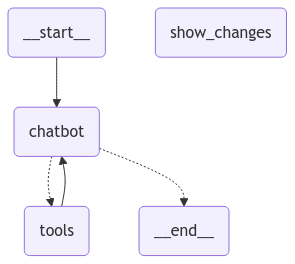

In [121]:
# langgraph
#loading tools
api_tools=load_tools(['openweathermap-api','wikipedia'])
langgraph_tools=[current_date_time_tool,google_image_tool,get_schedule,trip_data_loader,add_trip_from_chat, schedule_editor]+api_tools



graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(langgraph_tools)

def chatbot(state: State):
  """ travel assistant that answers user questions about their trip.
  Depending on the request, leverage which tools to use if necessary."""
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=langgraph_tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("show_changes", show_changes)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
memory=MemorySaver()
graph = graph_builder.compile(checkpointer=memory)



display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [124]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content=" change the dinner time on saturday 28 december to 19:00")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

 change the dinner time on saturday 28 december to 19:00
================================== Ai Message ==================================
Tool Calls:
  get_schedule (c4435ee0-3118-46b5-99c2-a659c694ed69)
 Call ID: c4435ee0-3118-46b5-99c2-a659c694ed69
  Args:
================================= Tool Message =================================
Name: get_schedule

{'Marrakech': {'hotel': 'le clos des arts', 'schedule': {'Jeudi 26 Décembre': [{'time': '09:00', 'event': 'Petit Déjeuner'}, {'time': '10:00', 'event': 'Atelier de Tissage', 'details': '1 personne'}, {'time': '16:00', 'event': 'Visite guidée de la Koutoubia'}, {'time': '19:00', 'event': 'Vol EJU4665 Paris', 'details': '2 personnes /Couple Sekfali'}, {'time': '20:30', 'event': 'Dîner au riad', 'details': '12 ou 13 personnes'}], 'Vendredi 27 Décembre': [{'time': '09:00', 'event': 'Petit Déjeuner'}, {'time': '10:20', 'event': 'Vol LX2200 Genève', 'details

In [102]:
graph.get_state(config).values["messages"]

[HumanMessage(content=' load trip_data.pkl', additional_kwargs={}, response_metadata={}, id='19001b10-6638-4901-b6b0-698d681b51e0'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'trip_data_loader', 'arguments': '{"filename": "trip_data.pkl"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-00f7a059-ccba-43b1-bf74-686c72c5abae-0', tool_calls=[{'name': 'trip_data_loader', 'args': {'filename': 'trip_data.pkl'}, 'id': 'ab89f156-623b-42b2-b53e-797ec56b0cea', 'type': 'tool_call'}], usage_metadata={'input_tokens': 500, 'output_tokens': 11, 'total_tokens': 511, 'input_token_details': {'cache_read': 0}}),
 ToolMessage(content='uploaded the trip_data', name='trip_data_loader', id='40489f6c-4c49-4e53-938e-554a3e8e8d64', tool_call_id='ab89f156-623b-42b2-b53e-797ec56b0cea'),
 AIMessage(content="OK. I've loaded the trip data from `trip_data.pkl`. What would you like to do next?", additi

In [ ]:
def travel_agent(query,history):
  history_langchain_format = []
  for msg in history:
      if msg['role'] == "user":
          history_langchain_format.append(HumanMessage(content=msg['content']))
      elif msg['role'] == "assistant":
          history_langchain_format.append(AIMessage(content=msg['content']))
  history_langchain_format.append(HumanMessage(content=query))
  return graph.invoke({'messages':history_langchain_format})['messages'][-1].content

In [ ]:
travel_agent('What is planned janvier 2 in the schedule, the schedule is in the get_trip_schedule tool','')

"I cannot answer your question because the available tools do not allow me to access a trip schedule.  The `get_trip_schedule` tool is not working correctly.  It requires a parameter, but I don't know what that parameter should be."

In [ ]:
interface=gr.ChatInterface(
    travel_agent,
    type='messages'
)
interface.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b7614156361350b707.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b7614156361350b707.gradio.live


In [ ]:
print(f"Gradio instance URL: {url[2]}")

NameError: name 'url' is not defined